In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

from make_gaussian_data import Gauz

#### A class to generate the data ( could be much simplier )

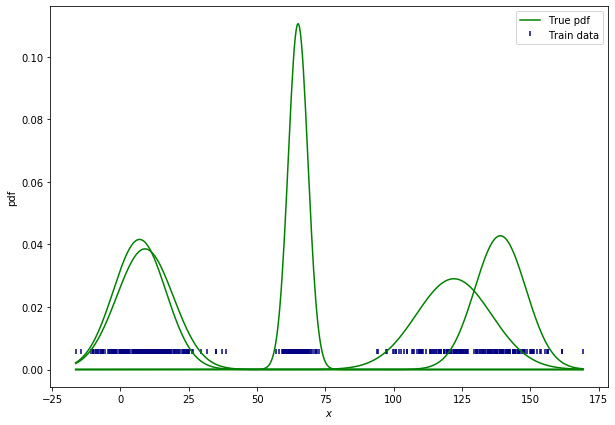

In [98]:
gg =Gauz(5, 500)
data = gg.variables
gg.plot()

#### Calculate probability that x belongs to K-th distribution
<img src='pics/gaussian.gif'>

In [3]:
def pdf(data, mean, sigma):
    s1 = 1/(np.sqrt(2*np.pi*sigma))
    s2 = np.exp(-(np.square(data - mean)/(2*sigma)))    
    return s1 * s2

Using Bayes theorem calculate (posterior) probablity that observation belongs to Gaussian distribution with some parametres(mean and sigma) G(k), we will be updating parameters untill converges or change is less than eps. <br>
<img src='pics/bayes.gif'> 

#### Update steps: <br>
We will use our posterior probability to update parametrs and to compute our prior probability. <br><img src="pics/updates.png">
At the beginning we intialize bk = 1/k, so that any observation have equal probability to belong G(k). Also,  in real world we do not know numeber of distrubutions G(k) present in our data and we need to guess k. But in our example we know k and it makes things a bit easier.


In [115]:
# number of clusters
k = 4
k_real = 5

bk_prior = np.ones((k)) / k  #  prior - > posterior

# random means and variances
means = np.random.choice(data, k)
variances = np.random.random_sample(size=k)
print(means, variances)

[137.21070328   6.18341173   9.74172366  17.60182149] [0.45859037 0.24835299 0.90260978 0.75957346]


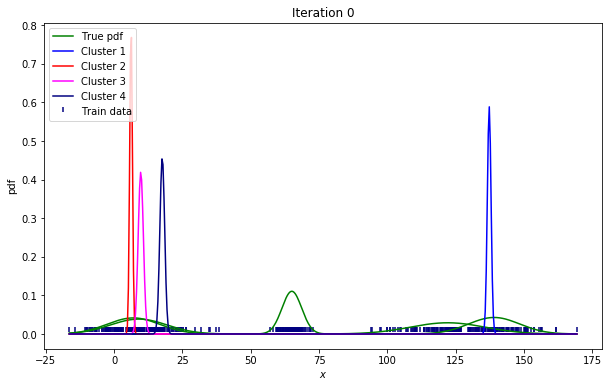

low prior for red [0.10592822 0.07532641 0.25       0.25      ]
check old means [137.16875362   5.41862606   9.74172366  17.60182149]
set new means [137.16875362 120.23536489   9.74172366  17.60182149]
low prior for magenta [0.10592822 0.07532641 0.09090826 0.25      ]
check old means [137.16875362 120.23536489  10.56161248  17.60182149]
set new means [137.16875362 120.23536489  65.51268058  17.60182149]
low prior for navy [0.10592822 0.07532641 0.09090826 0.0969526 ]
check old means [137.16875362 120.23536489  65.51268058  17.09335865]
set new means [137.16875362 120.23536489  65.51268058   5.04578086]


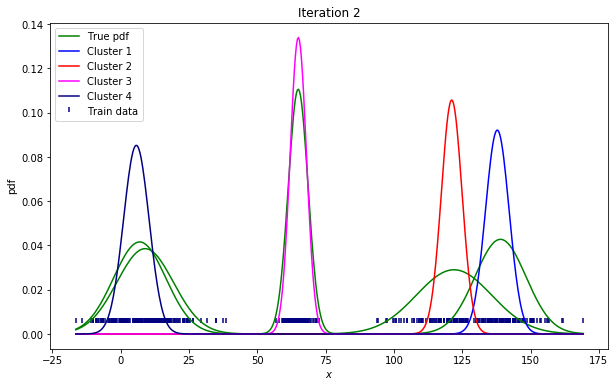

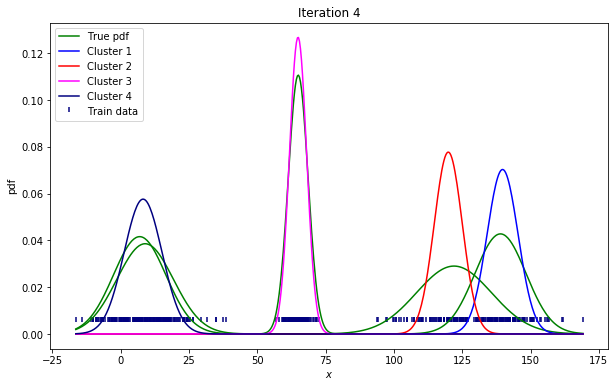

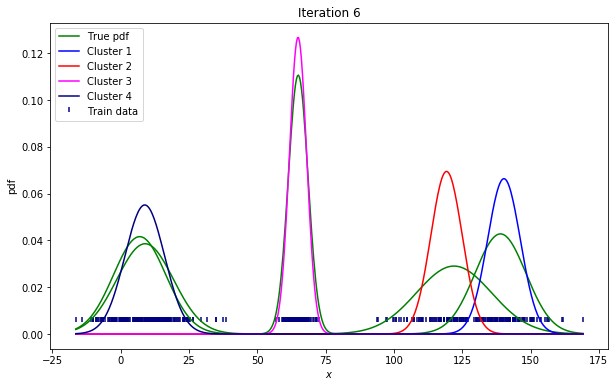

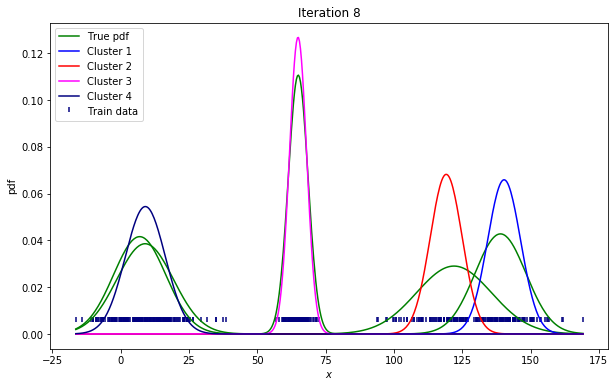

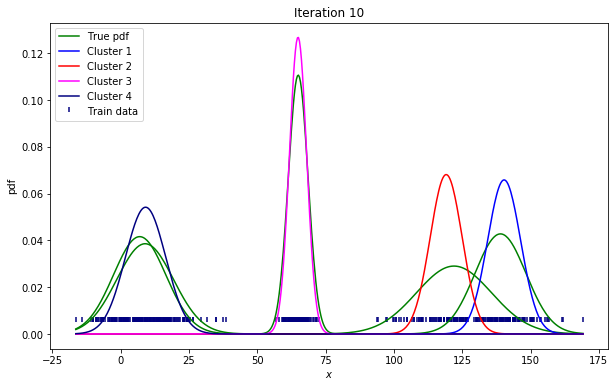

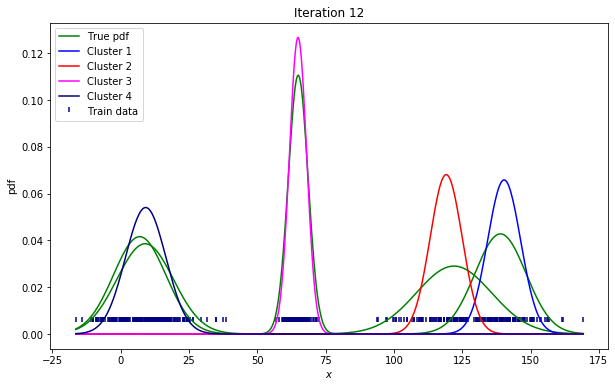

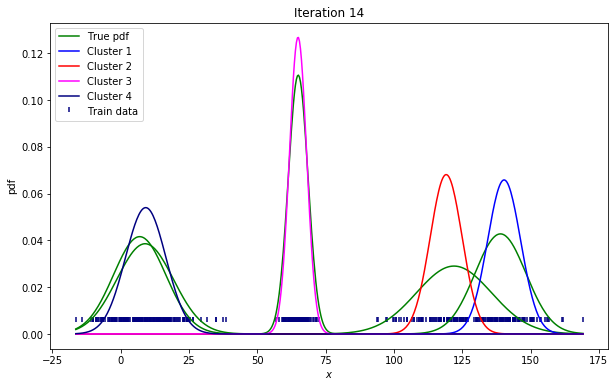

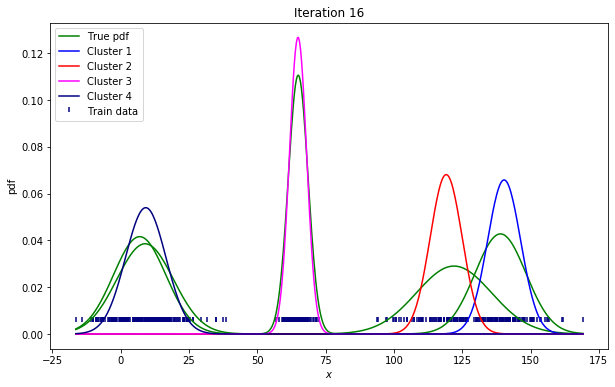

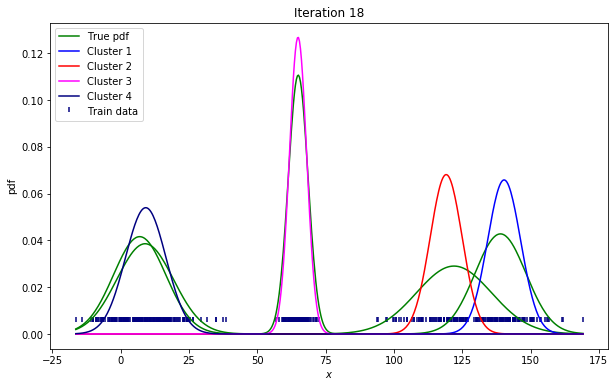

In [116]:
# to avoid division on 0
eps=1e-8 
X = data
num_steps = 20
bins = gg.bins
for step in range(num_steps):

    # small visualisaton 
    
    if step % 2 == 0:
        #print(f'means: {means}, variances: {variances}')
        plt.figure(figsize=(10,6))
        axes = plt.gca()
        plt.xlabel("$x$")
        plt.ylabel("pdf")
        plt.title("Iteration {}".format(step))
        plt.scatter(X, [0.005] * len(X), color='navy', s=30, marker=2, label="Train data")
        
        label="True pdf"
        col = ['blue','red','magenta','navy','orange','pink'][:k_real]
        for i, color in zip(range(k_real), col):
            plt.plot(bins, pdf(bins, gg.dists[i].m, gg.dists[i].sigma), color='green', label=label)
            label=None
        
        col = ['blue','red','magenta','navy','orange','pink'][:k]
        for i, color in zip(range(k), col):
            plt.plot(bins, pdf(bins, means[i], variances[i]), color=color, label=f"Cluster {i+1}")
           

        plt.legend(loc='upper left')
        #plt.savefig("img_{0:02d}".format(step), bbox_inches='tight')
        plt.show()
    # calculate the posterior probabilites with respect to each G(k) for each observation xi in data
    x_from_gk_probability = []
    for j in range(k):
        x_from_gk_probability.append(pdf(X, means[j], np.sqrt(variances[j])))
    x_from_gk_probability = np.array(x_from_gk_probability)

    # compute posterior probabilites and update values
    bk_posterior = []
    means_prev = np.array(means)
    for j in range(k):
        # use the current values for the parameters to evaluate the posterior
        # probabilities of the data to have been generanted by each gaussian   
        full_probability_x_gaussian =  np.sum([x_from_gk_probability[i] * bk_prior[i] for i in range(k)], axis=0)
                                        
        bk_posterior.append((x_from_gk_probability[j] * bk_prior[j])/(full_probability_x_gaussian+eps))

        # updage mean and variance
        means[j] = (np.sum(bk_posterior[j] * X) / (np.sum(bk_posterior[j]+eps)))
        variances[j] = np.sum(bk_posterior[j] * np.square(X - means[j])) / (np.sum(bk_posterior[j]+eps))

        # update prior_probabilities
        bk_prior[j] = np.mean(bk_posterior[j])
        if bk_prior[j] < 0.1 :  #np.array(bk_prior).mean():
            print(f'low prior for {col[j]} {bk_prior}')
            print(f'check old means {means}')
            r = np.random.randint(low=0, high=X.shape)
            means[j] = X[r]  # X[x_from_gk_probability[j].argsort()[::-1][r]] + eps
            print(f'set new means {means}')
            
#     if abs(np.sum(means_prev - np.array(means)))<eps:
#         break